# Data

NPZ: cache/encodec_acoustic/items/7cc00e4262dfdfd6154a.npz
D=17 T=87 C=4 bpm=138.0 drummer_id=1
resolved codec: encodec vocab_size: 2049 pad_id: 2048


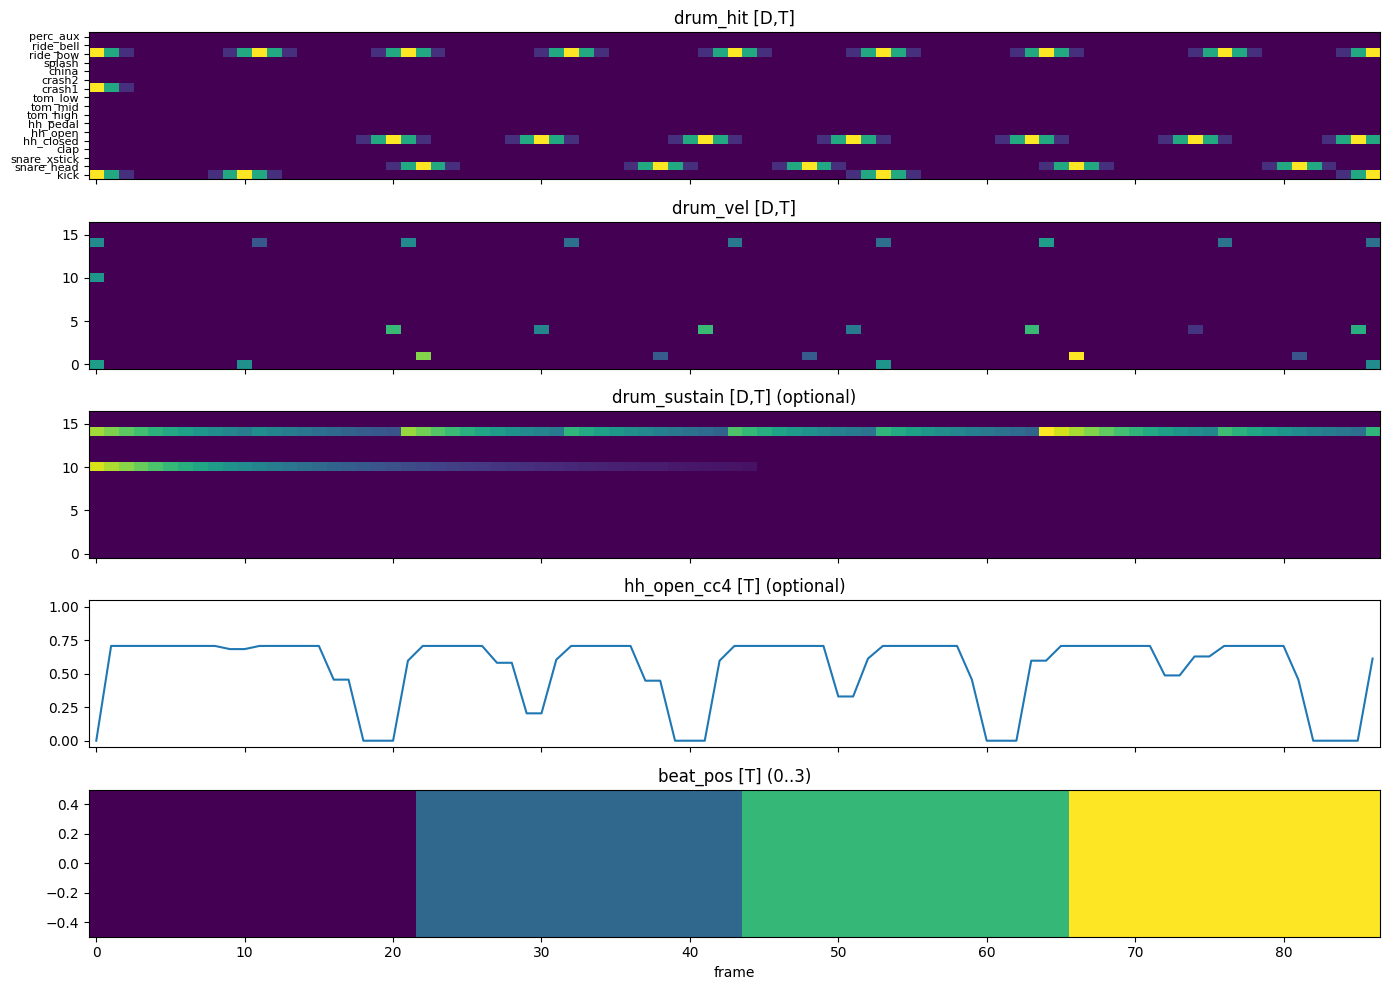

/home/ksoil/.conda/envs/ksoil_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


used sustain: False used hh_cc4: False
token_acc(masked): 0.31896551724137934 pred shape: (4, 87) tgt shape: (4, 87)


2026-01-27 14:42:24.042838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769517744.065986  969892 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769517744.071035  969892 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769517744.084979  969892 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769517744.084995  969892 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769517744.084996  969892 computation_placer.cc:177] computation placer alr

ref_rs: (55652,) gt_rs: (55652,) pr_rs: (55652,)
Original audio (resampled):


Codec reconstruction from ground-truth tokens (encodec) (resampled):


Model prediction decoded (encodec) (resampled):


L1(gt vs ref): 0.0047823903150856495
L1(pred vs ref): 0.01072035450488329


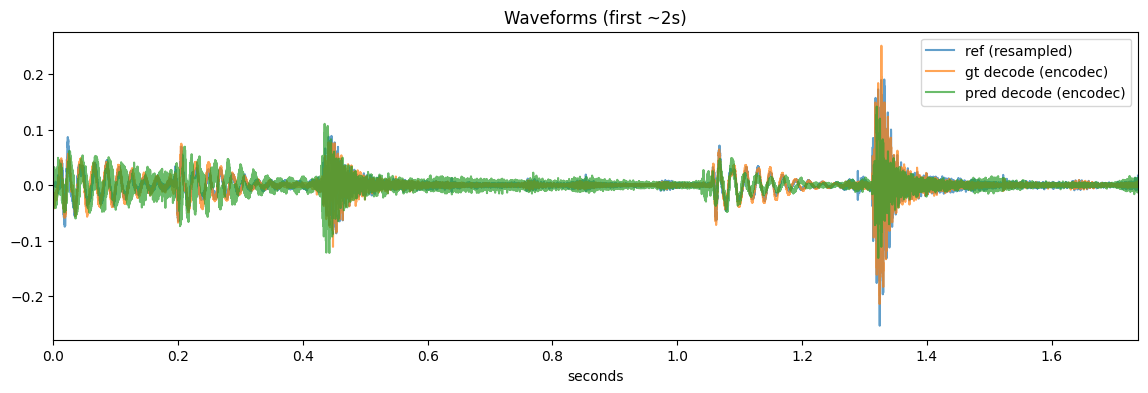

In [1]:
# One cell: load 1 cache item, resolve codec/vocab/pad from cache+ckpt, plot, run, decode, audio + plots
from pathlib import Path
import json, numpy as np, torch

CACHE_DIR = Path("cache/encodec_acoustic")  # xcodec_acoustic, dac_acoustic
CKPT_PATH = Path("artifacts/checkpoints/encodec_small_single_kit.pt") # expressivegrid_to_xcodec, expressivegrid_to_dac
DEVICE = "cuda:0"         # model forward
DECODE_DEVICE = "cuda:0"  # codec decode (set to "cpu" if VRAM is tight)
EVAL_SR = 32000

# --- pick 1 item ---
manifest = sorted(CACHE_DIR.glob("manifest_midigroove_test_*.jsonl"))[0]
rec = json.loads(manifest.read_text().splitlines()[0])
npz_path = Path(rec["npz"])
print("NPZ:", npz_path)

with np.load(npz_path, allow_pickle=False) as d:
    ex = {k: np.asarray(d[k]) for k in d.files}

# --- load conditioning + targets ---
drum_hit = ex["drum_hit"].astype(np.float32)                                # [D,T]
drum_vel = ex.get("drum_vel", np.zeros_like(drum_hit)).astype(np.float32)   # [D,T]
drum_sus = ex.get("drum_sustain", np.zeros_like(drum_hit)).astype(np.float32)  # [D,T]
hh_cc4   = ex.get("hh_open_cc4", np.zeros((drum_hit.shape[1],), np.float32)).astype(np.float32)  # [T]
beat_pos = ex["beat_pos"].astype(np.int64)                                  # [T]
bpm = float(ex.get("bpm", 120.0))
drummer_id = int(ex.get("drummer_id", 0))
tgt = ex["tgt"].astype(np.int64)                                            # [C,T]
D, T = drum_hit.shape
C = int(tgt.shape[0])
print(f"D={D} T={T} C={C} bpm={bpm} drummer_id={drummer_id}")

# --- resolve codec from cache semantics (fallback to ckpt cfg) ---
cache_sem = json.loads(str(ex.get("semantics", np.asarray("{}")).item() or "{}"))
cache_codec = str(cache_sem.get("encoder", "") or "").strip().lower() or None

from midigroove_poc import expressivegrid as eg
ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg = ckpt.get("cfg", {}) if isinstance(ckpt.get("cfg", {}), dict) else {}
ckpt_codec = str(cfg.get("encoder_model", "") or "").strip().lower() or None
codec = cache_codec or ckpt_codec or "encodec"

# --- resolve vocab_size / pad_id from ckpt (new) or infer from head (old) ---
num_codebooks = int(ckpt["num_codebooks"])
state = ckpt["model"]
vocab_size = int(cfg.get("vocab_size", 0) or 0)
if vocab_size <= 0:
    vs = eg._infer_vocab_size_from_state_dict(state, num_codebooks=num_codebooks)
    vocab_size = int(vs) if vs is not None else int(eg._vocab_size_for_codebook(eg._default_codebook_size_for_encoder(codec)))
pad_id = int(cfg.get("pad_id", vocab_size - 1 if vocab_size > 1 else 2048))

print("resolved codec:", codec, "vocab_size:", vocab_size, "pad_id:", pad_id)

# --- plotting inputs (always show all lanes) ---
try:
    import matplotlib.pyplot as plt
except Exception as e:
    raise RuntimeError("Install matplotlib in this env (e.g. `pip install matplotlib`)") from e

from data.midigroove_encodec_dataset import CHANNELS
fig, axs = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

axs[0].imshow(drum_hit, aspect="auto", origin="lower", interpolation="nearest")
axs[0].set_title("drum_hit [D,T]")
axs[0].set_yticks(range(len(CHANNELS)))
axs[0].set_yticklabels(CHANNELS, fontsize=8)

axs[1].imshow(drum_vel, aspect="auto", origin="lower", interpolation="nearest")
axs[1].set_title("drum_vel [D,T]")

axs[2].imshow(drum_sus, aspect="auto", origin="lower", interpolation="nearest")
axs[2].set_title("drum_sustain [D,T] (optional)")

axs[3].plot(hh_cc4)
axs[3].set_ylim(-0.05, 1.05)
axs[3].set_title("hh_open_cc4 [T] (optional)")

axs[4].imshow(beat_pos[None, :], aspect="auto", origin="lower", interpolation="nearest", vmin=0, vmax=3)
axs[4].set_title("beat_pos [T] (0..3)")
axs[4].set_xlabel("frame")

plt.tight_layout()
plt.show()

# --- build input grid respecting ckpt feature flags ---
include_sustain = bool(cfg.get("include_sustain", False))
include_hh_cc4 = bool(cfg.get("include_hh_cc4", False))

pieces = [drum_hit, drum_vel]
if include_sustain:
    pieces.append(drum_sus)
if include_hh_cc4:
    pieces.append(hh_cc4[None, :])

grid = np.concatenate(pieces, axis=0).astype(np.float32)  # [F,T]
in_dim = int(ckpt["in_dim"])
assert grid.shape[0] == in_dim and grid.shape[1] == T, (grid.shape, in_dim, T)

# --- run checkpoint -> predicted tokens ---
cfg2 = dict(cfg)
cfg2.setdefault("encoder_model", codec)
cfg2["vocab_size"] = int(vocab_size)
cfg2["pad_id"] = int(pad_id)

model = eg._build_model(num_codebooks=num_codebooks, in_dim=in_dim, cfg=cfg2)
model.load_state_dict(state, strict=True)
model.to(torch.device(DEVICE)).eval()

grid_t = torch.from_numpy(grid).unsqueeze(0).to(DEVICE)            # [1,F,T]
beat_pos_t = torch.from_numpy(beat_pos).unsqueeze(0).to(DEVICE)    # [1,T]
bpm_t = torch.tensor([bpm], dtype=torch.float32, device=DEVICE)    # [1]
drummer_id_t = torch.tensor([drummer_id], dtype=torch.long, device=DEVICE)  # [1]
valid_mask_t = torch.ones((1, T), dtype=torch.bool, device=DEVICE)

with torch.inference_mode():
    logits = model(grid=grid_t, beat_pos=beat_pos_t, bpm=bpm_t, drummer_id=drummer_id_t, valid_mask=valid_mask_t)  # [1,C,T,V]
    pred = logits.argmax(dim=-1).squeeze(0).to(torch.long).cpu()  # [C,T]

tgt_t = torch.from_numpy(tgt).to(torch.long)  # [C,T]
mask = tgt_t.ne(pad_id)
tok_acc_masked = float(((pred == tgt_t) & mask).sum().item() / max(1, mask.sum().item()))
print("used sustain:", include_sustain, "used hh_cc4:", include_hh_cc4)
print("token_acc(masked):", tok_acc_masked, "pred shape:", tuple(pred.shape), "tgt shape:", tuple(tgt_t.shape))

# for decoding: map PAD -> 0
pred_clean = torch.where(pred == pad_id, torch.zeros_like(pred), pred)
tgt_clean = torch.where(tgt_t == pad_id, torch.zeros_like(tgt_t), tgt_t)

# --- decode audio (prediction vs gt tokens) and compare to original segment ---
from IPython.display import Audio, display
from data.codecs import decode_tokens_to_audio
from midigroove_poc.eval import _load_audio_segment, _resample_linear

audio_path = Path(str(ex["audio_path"].item()))
sr_native = int(ex["sr"].item())
start_sec = float(ex["start_sec"].item())
window_seconds = float(ex["window_seconds"].item())
start_sample = int(round(start_sec * sr_native))
window_samples = int(round(window_seconds * sr_native))

ref, sr_ref = _load_audio_segment(audio_path, start_sample=start_sample, num_samples=window_samples)
ref_rs = _resample_linear(ref, sr_ref, EVAL_SR)

audio_gt_b1, sr_gt = decode_tokens_to_audio(tgt_clean, encoder_model=codec, device=DECODE_DEVICE)
audio_pr_b1, sr_pr = decode_tokens_to_audio(pred_clean, encoder_model=codec, device=DECODE_DEVICE)
gt_rs = _resample_linear(audio_gt_b1[0], sr_gt, EVAL_SR)
pr_rs = _resample_linear(audio_pr_b1[0], sr_pr, EVAL_SR)

N = min(ref_rs.size, gt_rs.size, pr_rs.size)
ref_rs, gt_rs, pr_rs = ref_rs[:N], gt_rs[:N], pr_rs[:N]

print("ref_rs:", ref_rs.shape, "gt_rs:", gt_rs.shape, "pr_rs:", pr_rs.shape)

print("Original audio (resampled):")
display(Audio(ref_rs, rate=EVAL_SR))
print(f"Codec reconstruction from ground-truth tokens ({codec}) (resampled):")
display(Audio(gt_rs, rate=EVAL_SR))
print(f"Model prediction decoded ({codec}) (resampled):")
display(Audio(pr_rs, rate=EVAL_SR))

# --- waveform comparison plots ---
import numpy as np
def l1(a, b): return float(np.mean(np.abs(a - b)))
print("L1(gt vs ref):", l1(gt_rs, ref_rs))
print("L1(pred vs ref):", l1(pr_rs, ref_rs))

t = np.arange(N) / float(EVAL_SR)
plt.figure(figsize=(14,4))
plt.plot(t, ref_rs, label="ref (resampled)", alpha=0.7)
plt.plot(t, gt_rs, label=f"gt decode ({codec})", alpha=0.7)
plt.plot(t, pr_rs, label=f"pred decode ({codec})", alpha=0.7)
plt.xlim(0, min(t[-1], 2.0))
plt.legend()
plt.title("Waveforms (first ~2s)")
plt.xlabel("seconds")
plt.show()


In [2]:
df['kit_name'].value_counts().sort_values(ascending=False)

kit_name
Acoustic Kit                       1059
JingleStacks (2nd Hi-Hat)          1059
Studio (Live Room)                 1059
Classic Rock                       1059
Jazz Funk                          1059
ClassicMetal (80s-90s)             1059
60s Rock                           1059
Modern Funk                        1059
Dark Hybrid                        1059
Big Room (Layered)                 1059
Raw Dnb (Layered Hybrid)           1059
Fat Rock (Power Toms)              1059
Pop-Rock (Studio)                  1059
Dry & Heavy (Folk Rock)            1059
Second Line                        1059
Heavy Metal                        1059
Arena Stage                        1059
Warmer Funk                        1059
Super Boom (Layered)               1059
Jazz                               1059
More Cowbell (Pop-Rock)            1059
Live Rock                          1059
Shuffle (Blues)                    1059
Alternative (METAL)                1059
Rockin Gate (80s)              

# Eval

,SI-SDR (dB) $\uparrow$,SI-SDR (dB) (oracle) $\uparrow$,RMSE $\downarrow$,RMSE (oracle) $\downarrow$,MR-STFT SC $\downarrow$,MR-STFT SC (oracle) $\downarrow$,Onset F1 $\uparrow$,Onset F1 (oracle) $\uparrow$,Onset timing (ms) $\downarrow$,Onset timing (ms) (oracle) $\downarrow$,FAD (PANN) (RMS=0.050) $\downarrow$,FAD (PANN) (RMS=0.050) (oracle) $\downarrow$
model,,,,,,,,,,,,
dac_small_single_kit,-37.06 ± 12.17,7.86 ± 4.00,0.0184 ± 0.0094,0.0060 ± 0.0025,0.982 ± 0.085,0.226 ± 0.071,0.774 ± 0.119,0.930 ± 0.059,15.92 ± 9.16,4.90 ± 3.74,2.037e-05,9.244e-06
encodec_small_single_kit,-25.25 ± 11.49,3.29 ± 4.39,0.0201 ± 0.0106,0.0089 ± 0.0034,0.842 ± 0.160,0.360 ± 0.090,0.772 ± 0.133,0.899 ± 0.067,16.67 ± 8.37,6.24 ± 4.06,7.544e-05,1.131e-04
xcodec_small_single_kit,-24.58 ± 11.48,0.28 ± 5.55,0.0305 ± 0.0176,0.0125 ± 0.0059,1.357 ± 0.702,0.426 ± 0.114,0.778 ± 0.124,0.888 ± 0.072,16.22 ± 8.05,6.90 ± 3.98,2.522e-05,9.611e-05


Wrote: artifacts/eval/small_one_kit/paper_figs


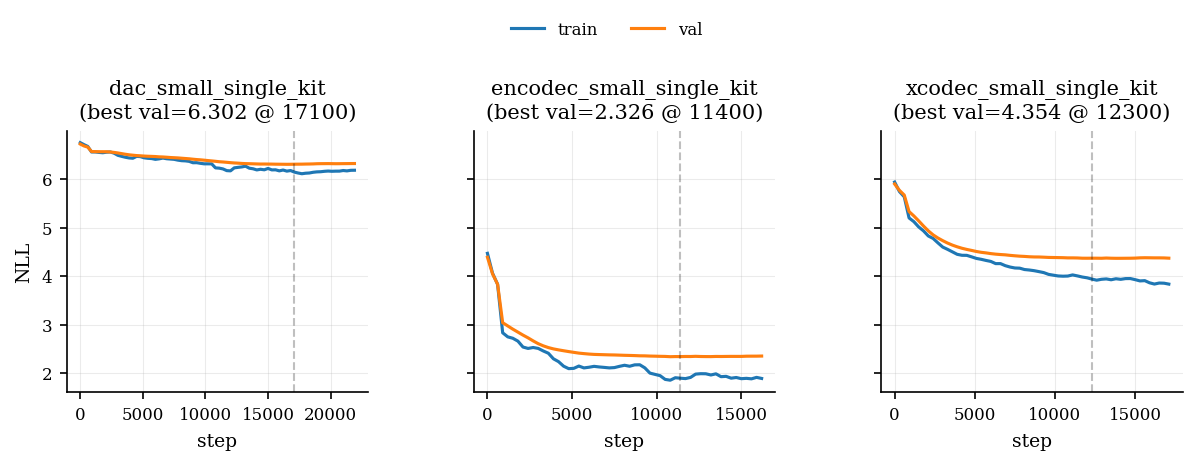

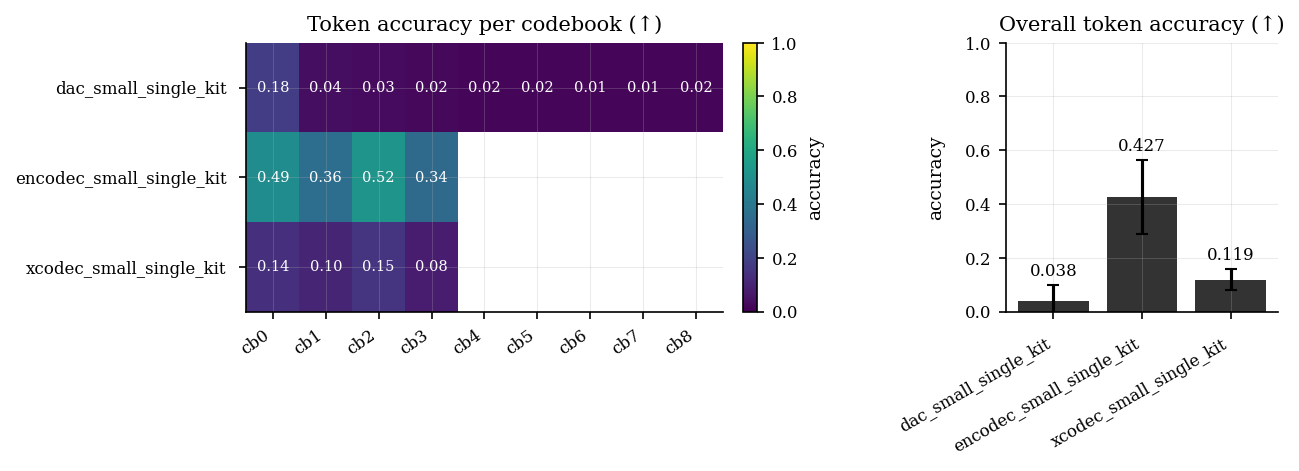

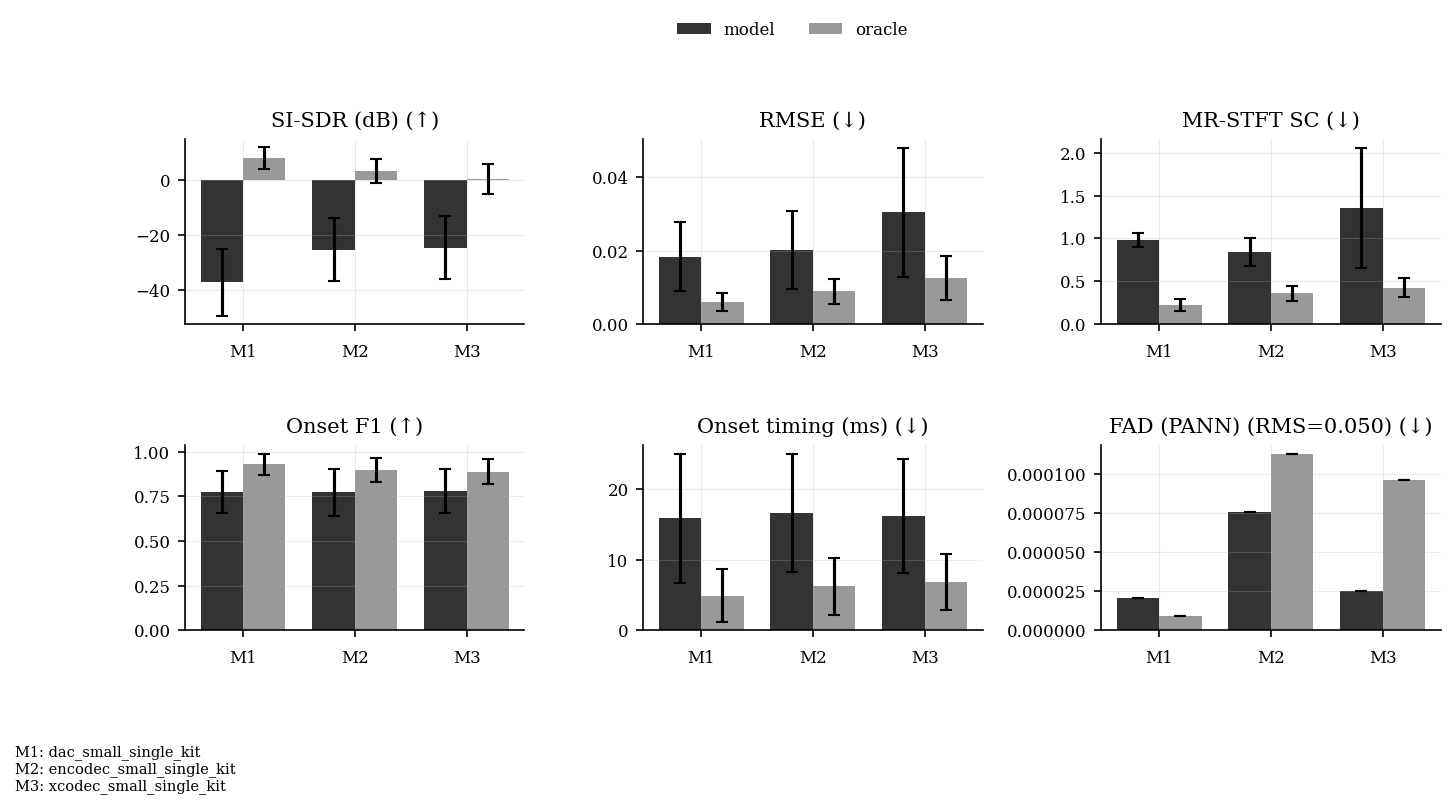

In [4]:
# Notebook snippet: plots + oracle-paired table (±) + arrows in plot + LaTeX
# FIXES:
# - remove the DAC/EnCodec/XCodec override (keeps checkpoint-derived names)
# - make checkpoint-derived names fit in plots (wrap + ellipsis, no overlap)
# - keep FAD in scientific notation and annotate with RMS used in eval.py

from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

OUT_DIR = Path("artifacts/eval/small_one_kit")  # <-- change
FIG_DIR = OUT_DIR / "paper_figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def set_paper_style():
    plt.rcParams.update(
        {
            "figure.dpi": 150,
            "savefig.dpi": 300,
            "font.size": 9,
            "font.family": "DejaVu Serif",
            "axes.titlesize": 10,
            "axes.labelsize": 9,
            "legend.fontsize": 8,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.25,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.5,
        }
    )

def load_eval(out_dir: Path):
    summary = json.loads((out_dir / "summary.json").read_text(encoding="utf-8"))
    items = pd.read_csv(out_dir / "items.csv")
    return summary, items

def _paper_model_label_from_stem(stem: str) -> str:
    s = str(stem)
    for prefix in ("expressivegrid_to_", "expressivegrid-to-", "eg_", "eg-"):
        if s.startswith(prefix):
            s = s[len(prefix):]
    return s.replace("__", "_").strip("_")

def _fit_xtick_label(s: str, *, max_chars: int = 22, wrap_at: int = 12) -> str:
    # checkpoint-derived, but shortened & wrapped to fit cleanly
    s = str(s)
    if len(s) > max_chars:
        s = s[: max_chars - 1] + "…"
    if len(s) > wrap_at:
        return "\n".join(textwrap.wrap(s, width=wrap_at))
    return s

def base_systems(summary: dict) -> list[str]:
    return sorted([k for k in summary["systems"].keys() if not k.endswith(("_oracle", "_random"))])

def ckpt_from_summary(summary: dict, system: str) -> Path | None:
    p = summary["systems"].get(system, {}).get("ckpt")
    return Path(p) if isinstance(p, str) and p else None

def label_for_base(summary: dict, base: str) -> str:
    ckpt = ckpt_from_summary(summary, base)
    return _paper_model_label_from_stem(ckpt.stem) if ckpt is not None else base

def find_train_metrics_csv(summary: dict, system: str) -> Path | None:
    ckpt = ckpt_from_summary(summary, system)
    if ckpt is None:
        return None
    p = Path(str(ckpt) + ".metrics.csv")
    return p if p.is_file() else None

def plot_training_grid(summary: dict, systems, labels, fig_dir: Path, smoothing_window: int = 5):
    set_paper_style()
    n = len(systems)
    fig, axes = plt.subplots(1, n, figsize=(3.2 * n, 2.6), sharey=True)
    if n == 1:
        axes = [axes]

    handles = None
    leg_labels = None

    for ax, sys, lab in zip(axes, systems, labels):
        p = find_train_metrics_csv(summary, sys)
        if p is None:
            ax.set_title(f"{lab} (no train log)")
            ax.set_axis_off()
            continue

        df = pd.read_csv(p).sort_values("step")
        best_val = float(df["val_loss"].min()) if "val_loss" in df.columns and len(df) else float("nan")
        best_step = int(df.loc[df["val_loss"].idxmin(), "step"]) if "val_loss" in df.columns and len(df) else None

        x = df["step"].to_numpy()
        tr = df["train_loss"].to_numpy()
        va = df["val_loss"].to_numpy()

        if smoothing_window and smoothing_window > 1 and len(df) >= smoothing_window:
            tr = pd.Series(tr).rolling(smoothing_window, center=True, min_periods=1).mean().to_numpy()
            va = pd.Series(va).rolling(smoothing_window, center=True, min_periods=1).mean().to_numpy()

        l1, = ax.plot(x, tr, label="train", color="C0")
        l2, = ax.plot(x, va, label="val", color="C1")
        if handles is None:
            handles = [l1, l2]
            leg_labels = ["train", "val"]

        if best_step is not None:
            ax.axvline(best_step, color="k", alpha=0.25, linewidth=1.0, linestyle="--")

        ax.set_title(f"{lab}\n(best val={best_val:.3f}" + (f" @ {best_step}" if best_step is not None else "") + ")")
        ax.set_xlabel("step")
        ax.set_ylabel("NLL" if ax is axes[0] else "")

    if handles is not None:
        fig.legend(handles, leg_labels, frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.10))

    fig.subplots_adjust(top=0.78, wspace=0.35)
    fig.savefig(fig_dir / "training_curves_grid.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "training_curves_grid.png", bbox_inches="tight")
    return fig

def token_acc_summary(items: pd.DataFrame):
    cb_cols = sorted(
        [c for c in items.columns if c.startswith("token_acc_cb")],
        key=lambda s: int(s.replace("token_acc_cb", "")),
    )
    overall = items.groupby("system")["token_acc"].agg(["mean", "std", "count"]).rename(columns={"count": "n"})
    per_cb_mean = items.groupby("system")[cb_cols].mean()
    per_cb_std = items.groupby("system")[cb_cols].std()
    return overall, per_cb_mean, per_cb_std, cb_cols

def _short_model_label(s: str) -> str:
    s = str(s)
    for prefix in ("expressivegrid_to_", "expressivegrid-to-", "eg_", "eg-"):
        if s.startswith(prefix):
            s = s[len(prefix):]
    return s.replace("__", "_").strip("_")

def _text_color_for_value(v: float) -> str:
    return "white" if np.isfinite(v) and v < 0.55 else "black"

def plot_token_acc(systems, labels, overall, per_cb_mean, cb_cols, fig_dir: Path, *, heatmap_decimals: int = 2, bar_decimals: int = 3):
    set_paper_style()
    ylabels = [_short_model_label(l) for l in labels]
    xlabels = ylabels
    heat = per_cb_mean.reindex(systems)[cb_cols]

    fig = plt.figure(figsize=(8.6, 3.2))
    gs = fig.add_gridspec(1, 2, width_ratios=[2.1, 1.1])
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    arr = heat.to_numpy()
    im = ax0.imshow(arr, aspect="auto", vmin=0.0, vmax=1.0, cmap="viridis")
    ax0.set_title("Token accuracy per codebook (↑)")
    ax0.set_yticks(range(len(systems)))
    ax0.set_yticklabels(ylabels)
    ax0.set_xticks(range(len(cb_cols)))
    ax0.set_xticklabels([c.replace("token_acc_cb", "cb") for c in cb_cols], rotation=35, ha="right")
    ax0.tick_params(axis="y", pad=6)

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            v = arr[i, j]
            if not np.isfinite(v):
                continue
            ax0.text(j, i, f"{v:.{heatmap_decimals}f}", ha="center", va="center", fontsize=7, color=_text_color_for_value(float(v)))

    cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
    cbar.set_label("accuracy")

    o = overall.reindex(systems)
    x = np.arange(len(systems))
    means = o["mean"].to_numpy()
    stds = o["std"].to_numpy()
    bars = ax1.bar(x, means, yerr=stds, capsize=3, color="0.2")
    ax1.set_title("Overall token accuracy (↑)")
    ax1.set_ylim(0.0, 1.0)
    ax1.set_xticks(x)
    ax1.set_xticklabels(xlabels, rotation=30, ha="right")
    ax1.set_ylabel("accuracy", labelpad=18)
    ax1.yaxis.set_label_coords(-0.22, 0.5)
    ax1.tick_params(axis="x", pad=8)

    for b, m, s in zip(bars, means, stds):
        if not np.isfinite(m):
            continue
        y = float(m) + (float(s) if np.isfinite(s) else 0.0) + 0.02
        ax1.text(b.get_x() + b.get_width() / 2.0, min(0.98, y), f"{float(m):.{bar_decimals}f}", ha="center", va="bottom", fontsize=8, color="black")

    fig.subplots_adjust(left=0.18, bottom=0.32, right=0.98, wspace=0.60)
    fig.savefig(fig_dir / "token_accuracy_grid.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "token_accuracy_grid.png", bbox_inches="tight")
    return fig

# ---------- Oracle-paired audio/FAD table (default) ----------

_METRICS = [
    ("sisdr",            "SI-SDR (dB)",           "up",   2),
    ("rmse",             "RMSE",                  "down", 4),
    ("mr_stft_sc",       "MR-STFT SC",            "down", 3),
    ("onset_f1",         "Onset F1",              "up",   3),
    ("onset_timing_ms",  "Onset timing (ms)",     "down", 2),
    ("fad_pann",         "FAD (PANN)",            "down", 0),  # handled specially (sci)
]

def _arrow_tex(direction: str) -> str:
    return r"$\uparrow$" if direction == "up" else r"$\downarrow$"

def _fmt_mean_std(v, *, decimals: int) -> str:
    if isinstance(v, dict) and "mean" in v:
        m = v.get("mean", None)
        s = v.get("std", None)
        if isinstance(m, (int, float)) and np.isfinite(m):
            if isinstance(s, (int, float)) and np.isfinite(s):
                return f"{m:.{decimals}f} ± {s:.{decimals}f}"
            return f"{m:.{decimals}f}"
    if isinstance(v, (int, float)) and np.isfinite(v):
        return f"{float(v):.{decimals}f}"
    return ""

def _fmt_fad(v) -> str:
    if isinstance(v, (int, float)) and np.isfinite(v):
        return f"{float(v):.3e}"
    return ""

def _get_metric(summary: dict, system: str, key: str):
    sysd = summary["systems"].get(system, {})
    if key == "fad_pann":
        fad = sysd.get("fad", {})
        return fad.get("pann") if isinstance(fad, dict) else None
    return sysd.get(key, None)

def oracle_paired_table(summary: dict, bases: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    rows_pretty = []
    rows_csv = []

    fad_rms = summary.get("fad_target_rms", None)
    fad_note = f" (RMS={fad_rms:.3f})" if isinstance(fad_rms, (int, float)) and np.isfinite(fad_rms) else ""

    for b in bases:
        o = f"{b}_oracle"
        has_oracle = o in summary["systems"]

        row_pretty = {"model": label_for_base(summary, b)}
        row_csv = {"model": label_for_base(summary, b)}

        for key, disp, direction, dec in _METRICS:
            arrow_t = _arrow_tex(direction)
            v_b = _get_metric(summary, b, key)
            v_o = _get_metric(summary, o, key) if has_oracle else None

            if key == "fad_pann":
                disp2 = disp + fad_note
                pretty_base_col = f"{disp2} {arrow_t}"
                pretty_orac_col = f"{disp2} (oracle) {arrow_t}"
                row_pretty[pretty_base_col] = _fmt_fad(v_b)
                row_pretty[pretty_orac_col] = _fmt_fad(v_o) if has_oracle else ""
                row_csv[key] = _fmt_fad(v_b)
                row_csv[f"{key}_oracle"] = _fmt_fad(v_o) if has_oracle else ""
                continue

            pretty_base_col = f"{disp} {arrow_t}"
            pretty_orac_col = f"{disp} (oracle) {arrow_t}"
            row_pretty[pretty_base_col] = _fmt_mean_std(v_b, decimals=dec)
            row_pretty[pretty_orac_col] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""

            row_csv[key] = _fmt_mean_std(v_b, decimals=dec)
            row_csv[f"{key}_oracle"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""

        rows_pretty.append(row_pretty)
        rows_csv.append(row_csv)

    tbl_pretty = pd.DataFrame(rows_pretty).set_index("model")
    tbl_csv = pd.DataFrame(rows_csv).set_index("model")
    return tbl_pretty, tbl_csv

def plot_audio_metrics_with_oracle(summary: dict, bases: list[str], fig_dir: Path):
    set_paper_style()

    # Full checkpoint-derived names
    full = [label_for_base(summary, b) for b in bases]

    # Short plot IDs (paper-friendly)
    short = [f"M{i+1}" for i in range(len(bases))]

    # Save mapping for paper/caption
    map_lines = ["Model ID mapping:"]
    for s, f in zip(short, full):
        map_lines.append(f"  {s}: {f}")
    (fig_dir / "model_id_mapping.txt").write_text("\n".join(map_lines) + "\n", encoding="utf-8")

    x = np.arange(len(bases))

    fad_rms = summary.get("fad_target_rms", None)
    fad_note = f" (RMS={fad_rms:.3f})" if isinstance(fad_rms, (int, float)) and np.isfinite(fad_rms) else ""

    n_metrics = len(_METRICS)
    ncols = 3
    nrows = int(np.ceil(n_metrics / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.6 * ncols, 2.6 * nrows), squeeze=False)

    for idx, (key, disp, direction, _dec) in enumerate(_METRICS):
        ax = axes[idx // ncols][idx % ncols]
        arrow = "↑" if direction == "up" else "↓"

        means_b, stds_b = [], []
        means_o, stds_o = [], []

        for b in bases:
            o = f"{b}_oracle"
            vb = _get_metric(summary, b, key)
            vo = _get_metric(summary, o, key) if o in summary["systems"] else None

            def _ms(v):
                if isinstance(v, dict) and isinstance(v.get("mean"), (int, float)) and np.isfinite(v["mean"]):
                    m = float(v["mean"])
                    s = float(v.get("std")) if isinstance(v.get("std"), (int, float)) and np.isfinite(v.get("std")) else 0.0
                    return m, s
                if isinstance(v, (int, float)) and np.isfinite(v):
                    return float(v), 0.0
                return np.nan, 0.0

            mb, sb = _ms(vb)
            mo, so = _ms(vo)
            means_b.append(mb); stds_b.append(sb)
            means_o.append(mo); stds_o.append(so)

        means_b = np.asarray(means_b, dtype=float)
        stds_b = np.asarray(stds_b, dtype=float)
        means_o = np.asarray(means_o, dtype=float)
        stds_o = np.asarray(stds_o, dtype=float)

        w = 0.38
        ax.bar(x - w/2, means_b, w, yerr=stds_b, capsize=3, label="model", color="0.2")
        ax.bar(x + w/2, means_o, w, yerr=stds_o, capsize=3, label="oracle", color="0.6")

        title = f"{disp}{fad_note} ({arrow})" if key == "fad_pann" else f"{disp} ({arrow})"
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(short, rotation=0, ha="center")
        ax.tick_params(axis="x", pad=6)

    for j in range(n_metrics, nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    handles, leg_labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, leg_labels, frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

    # Put the mapping inside the figure (small text) so it's self-contained
    map_text = "\n".join([f"{s}: {f}" for s, f in zip(short, full)])
    fig.text(0.02, 0.01, map_text, ha="left", va="bottom", fontsize=7)

    fig.subplots_adjust(top=0.85, hspace=0.65, wspace=0.35, bottom=0.22)
    fig.savefig(fig_dir / "audio_metrics_oracle_bars.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "audio_metrics_oracle_bars.png", bbox_inches="tight")
    return fig

# ---- run ----
summary, items = load_eval(OUT_DIR)
bases = base_systems(summary)

plot_training_grid(summary, bases, [label_for_base(summary, b) for b in bases], FIG_DIR, smoothing_window=5)

overall, per_cb_mean, per_cb_std, cb_cols = token_acc_summary(items)
plot_token_acc(bases, [label_for_base(summary, b) for b in bases], overall, per_cb_mean, cb_cols, FIG_DIR)

tbl_pretty, tbl_csv = oracle_paired_table(summary, bases)
display(tbl_pretty)

tbl_csv.to_csv(FIG_DIR / "audio_fad_oracle_table.csv")
tbl_pretty.to_latex(FIG_DIR / "audio_fad_oracle_table.tex", escape=False)
tbl_pretty.to_csv(FIG_DIR / "audio_fad_oracle_table_pretty.csv")

plot_audio_metrics_with_oracle(summary, bases, FIG_DIR)

print("Wrote:", FIG_DIR)

# FAD check

In [2]:
# Sanity checks for FAD(PANN): does it separate obvious wrong audio?
# - FAD(ref, ref) should be ~0
# - FAD(ref, pred) should be > 0
# - FAD(ref, shuffled_pred) should be >= FAD(ref, pred)
# - FAD(ref, noise) should be much larger than ref/pred
# - FAD(ref, oracle) should usually be <= FAD(ref, pred)

from pathlib import Path
import random
import shutil
import numpy as np

from frechet_audio_distance import FrechetAudioDistance

RUN = Path("artifacts/pred/small_one_kit")  # <-- change
SYS = "encodec"  # <-- change: "dac" | "encodec" | "xcodec"
EVAL_SR = 32000  # <-- must match what eval saved

ref_dir    = RUN / "ref_by_system" / SYS
pred_dir   = RUN / "pred" / SYS
oracle_dir = RUN / "oracle" / SYS

assert ref_dir.is_dir(), ref_dir
assert pred_dir.is_dir(), pred_dir

fad = FrechetAudioDistance(
    model_name="pann",
    sample_rate=int(EVAL_SR),
    use_pca=False,
    use_activation=False,
    verbose=False,
)

def _list_wavs(d: Path):
    return sorted([p for p in d.rglob("*.wav") if p.is_file()])

def _make_clean_dir(d: Path):
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

def _copy_subset(src: Path, dst: Path, wavs: list[Path]):
    _make_clean_dir(dst)
    for p in wavs:
        rel = p.relative_to(src)
        out = dst / rel
        out.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(p, out)

def _shuffled_pred_subset(ref_wavs: list[Path], pred_wavs: list[Path], dst: Path):
    # copy preds but with filenames matching refs (pairing wrong items)
    _make_clean_dir(dst)
    pred_shuf = pred_wavs[:]
    random.shuffle(pred_shuf)
    for r, p in zip(ref_wavs, pred_shuf):
        out = dst / r.name  # flatten OK for FAD
        shutil.copy2(p, out)

def _noise_like_ref_subset(ref_wavs: list[Path], dst: Path):
    # white noise with same length as each ref file (requires soundfile)
    import soundfile as sf
    _make_clean_dir(dst)
    rng = np.random.default_rng(0)
    for r in ref_wavs:
        y, sr = sf.read(r, dtype="float32", always_2d=False)
        assert int(sr) == int(EVAL_SR), (sr, EVAL_SR, r)
        if y.ndim > 1:
            y = y.mean(axis=-1)
        n = rng.standard_normal(size=y.shape[0]).astype("float32")
        # match RMS roughly
        rms_y = float(np.sqrt(np.mean(np.square(y)) + 1e-12))
        rms_n = float(np.sqrt(np.mean(np.square(n)) + 1e-12))
        n = n * (rms_y / max(1e-8, rms_n))
        sf.write(dst / r.name, n, int(EVAL_SR))

def score(a: Path, b: Path) -> float:
    return float(fad.score(str(a), str(b), dtype="float32"))

# ---- run checks on a subset for speed ----
ref_wavs  = _list_wavs(ref_dir)
pred_wavs = _list_wavs(pred_dir)
assert len(ref_wavs) == len(pred_wavs), (len(ref_wavs), len(pred_wavs))

N = min(512, len(ref_wavs))  # <-- increase for stability
random.seed(0)
idx = random.sample(range(len(ref_wavs)), k=N)
ref_sub  = [ref_wavs[i] for i in idx]
pred_sub = [pred_wavs[i] for i in idx]

TMP = RUN / "fad_sanity_tmp" / SYS
ref_tmp     = TMP / "ref"
pred_tmp    = TMP / "pred"
shuf_tmp    = TMP / "pred_shuffled"
noise_tmp   = TMP / "noise"
oracle_tmp  = TMP / "oracle"

_copy_subset(ref_dir, ref_tmp, ref_sub)
_copy_subset(pred_dir, pred_tmp, pred_sub)
_shuffled_pred_subset(ref_sub, pred_sub, shuf_tmp)
_noise_like_ref_subset(ref_sub, noise_tmp)

print(f"Subset N={N} @ sr={EVAL_SR} sys={SYS}")
fad_ref_ref   = score(ref_tmp, ref_tmp)
fad_ref_pred  = score(ref_tmp, pred_tmp)
fad_ref_shuf  = score(ref_tmp, shuf_tmp)
fad_ref_noise = score(ref_tmp, noise_tmp)

print(f"FAD(ref, ref)        = {fad_ref_ref:.8e}")
print(f"FAD(ref, pred)       = {fad_ref_pred:.8e}")
print(f"FAD(ref, shuffled)   = {fad_ref_shuf:.8e}")
print(f"FAD(ref, noise)      = {fad_ref_noise:.8e}")

if oracle_dir.is_dir():
    oracle_wavs = _list_wavs(oracle_dir)
    if len(oracle_wavs) >= N:
        oracle_sub = [oracle_wavs[i] for i in idx]
        _copy_subset(oracle_dir, oracle_tmp, oracle_sub)
        fad_ref_oracle = score(ref_tmp, oracle_tmp)
        print(f"FAD(ref, oracle)     = {fad_ref_oracle:.8e}")
    else:
        print("Oracle present but not enough wavs for subset.")

print("Tmp written to:", TMP)


/home/ksoil/.conda/envs/ksoil_torch/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2026-01-27 14:20:23.904955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 14:20:23.926501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769516423.949867  966090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:176951642

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Subset N=512 @ sr=32000 sys=encodec
FAD(ref, ref)        = 0.00000000e+00
FAD(ref, pred)       = 1.04485473e-04
FAD(ref, shuffled)   = 1.04485542e-04
FAD(ref, noise)      = 3.97928129e-03
FAD(ref, oracle)     = 9.13050551e-05
Tmp written to: artifacts/pred/small_one_kit/fad_sanity_tmp/encodec


In [3]:
# Optional: check if FAD is mostly driven by loudness (RMS) mismatch
# (If FAD barely changes after RMS-normalizing, it’s not sensitive to your errors.)

from pathlib import Path
import numpy as np
import shutil
import soundfile as sf
from frechet_audio_distance import FrechetAudioDistance

RUN = Path("artifacts/pred/small_one_kit")  # <-- change
SYS = "encodec"
EVAL_SR = 32000

ref_dir  = RUN / "ref_by_system" / SYS
pred_dir = RUN / "pred" / SYS

fad = FrechetAudioDistance(model_name="pann", sample_rate=int(EVAL_SR), use_pca=False, use_activation=False, verbose=False)

def _list_wavs(d: Path):
    return sorted([p for p in d.rglob("*.wav") if p.is_file()])

def _make_clean_dir(d: Path):
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

def _rms_normalize_tree(src: Path, dst: Path, target_rms: float = 0.05):
    _make_clean_dir(dst)
    for p in _list_wavs(src):
        y, sr = sf.read(p, dtype="float32", always_2d=False)
        assert int(sr) == int(EVAL_SR), (sr, EVAL_SR, p)
        if y.ndim > 1:
            y = y.mean(axis=-1)
        rms = float(np.sqrt(np.mean(np.square(y)) + 1e-12))
        y = y * (float(target_rms) / max(1e-8, rms))
        out = dst / p.name
        sf.write(out, y, int(EVAL_SR))

TMP = RUN / "fad_rms_tmp" / SYS
ref_n = TMP / "ref_norm"
pred_n = TMP / "pred_norm"

ref = RUN / "fad_sanity_tmp" / SYS / "ref"     # reuse subset from previous snippet if present
pred = RUN / "fad_sanity_tmp" / SYS / "pred"

if not ref.is_dir():
    ref = ref_dir
if not pred.is_dir():
    pred = pred_dir

_rms_normalize_tree(ref, ref_n, target_rms=0.05)
_rms_normalize_tree(pred, pred_n, target_rms=0.05)

fad_raw = float(fad.score(str(ref), str(pred), dtype="float32"))
fad_norm = float(fad.score(str(ref_n), str(pred_n), dtype="float32"))

print(f"FAD raw  = {fad_raw:.8e}")
print(f"FAD norm = {fad_norm:.8e}")
print("Tmp written to:", TMP)


FAD raw  = 1.04485473e-04
FAD norm = 6.90986709e-05
Tmp written to: artifacts/pred/small_one_kit/fad_rms_tmp/encodec


In [4]:
# 1) Verify the "noise" files are actually noise (not accidentally refs)
import numpy as np
import soundfile as sf
from pathlib import Path

RUN = Path("artifacts/pred/small_one_kit")
SYS = "encodec"
ref_dir  = RUN / "fad_sanity_tmp" / SYS / "ref"
noise_dir = RUN / "fad_sanity_tmp" / SYS / "noise"

p = sorted(ref_dir.glob("*.wav"))[0]
r, sr = sf.read(p, dtype="float32")
n, sr2 = sf.read(noise_dir / p.name, dtype="float32")
m = min(len(r), len(n))
r = r[:m]; n = n[:m]

print("sr:", sr, sr2)
print("rms ref  :", float(np.sqrt(np.mean(r*r) + 1e-12)))
print("rms noise:", float(np.sqrt(np.mean(n*n) + 1e-12)))
print("corr(ref,noise):", float(np.corrcoef(r, n)[0,1]))
print("max|ref-noise|:", float(np.max(np.abs(r - n))))


sr: 32000 32000
rms ref  : 0.018466919940025577
rms noise: 0.018466944367979733
corr(ref,noise): -0.011389231786207911
max|ref-noise|: 0.28985595703125


In [5]:
# 2) Make more extreme baselines: silence + full-scale noise (no RMS matching)
#    Expect: FAD(ref, silence) and FAD(ref, loud_noise) >> FAD(ref, pred)
import numpy as np
import soundfile as sf
import shutil
from pathlib import Path
from frechet_audio_distance import FrechetAudioDistance

RUN = Path("artifacts/pred/small_one_kit")
SYS = "encodec"
EVAL_SR = 32000

ref_tmp = RUN / "fad_sanity_tmp" / SYS / "ref"
sil_dir = RUN / "fad_sanity_tmp" / SYS / "silence"
ln_dir  = RUN / "fad_sanity_tmp" / SYS / "loud_noise"

def clean(d: Path):
    if d.exists(): shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

clean(sil_dir); clean(ln_dir)

for p in sorted(ref_tmp.glob("*.wav")):
    y, sr = sf.read(p, dtype="float32")
    assert int(sr) == int(EVAL_SR)
    sf.write(sil_dir / p.name, np.zeros_like(y), int(EVAL_SR))
    # loud full-scale noise (no RMS match)
    rng = np.random.default_rng(0)
    n = rng.standard_normal(size=y.shape).astype("float32")
    n = n / (np.max(np.abs(n)) + 1e-8) * 0.95
    sf.write(ln_dir / p.name, n, int(EVAL_SR))

fad = FrechetAudioDistance(model_name="pann", sample_rate=int(EVAL_SR), use_pca=False, use_activation=False, verbose=False)
print("FAD(ref, silence)   =", float(fad.score(str(ref_tmp), str(sil_dir), dtype="float32")))
print("FAD(ref, loud_noise)=", float(fad.score(str(ref_tmp), str(ln_dir), dtype="float32")))


FAD(ref, silence)   = 0.0012766431810890128
FAD(ref, loud_noise)= 0.010015889484986912
